In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105  # zf: this is joint_n * (joint_n-1). the (flatten) diemsnion of JDC
        self.filters = 16
        self.data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB')
C = Config()
print(C.__dict__)
assert C.feat_d == C.joint_n*(C.joint_n-1) / 2, "feat_d should be the JCD dimension"

{'frame_l': 32, 'joint_n': 15, 'joint_d': 2, 'clc_num': 21, 'feat_d': 105, 'filters': 16, 'data_dir': '/home/zf/video-analytics/DD-Net/JHMDB/../data/JHMDB'}


In [4]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        # interploate to the right number of frames
        assert p.shape == (C.frame_l, C.joint_n, C.joint_d)

        label = np.zeros(C.clc_num)  # one-hot encoding
        label[le.transform(T['label'])[i]] = 1   # zf: why -1? it shifts all labels to the left by 1, though still valid

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
# helper functions for plotting
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Train and test on GT_split 1

In [7]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 268/268 [00:00<00:00, 328.40it/s]


### Data Dimensions and Examples

In [8]:
print([(k, type(v)) for k,v in Train.items()])
print(list(map(np.shape, Train['pose'][:5])))
print(len(Train['label']), Train['label'][0])
# the first dimension of each data point is the frame length, which is variable from the authors,
# which is why they use zoom() to rescale them to fixed frame length
# print(Train['pose'][0])

print(X_0.shape, X_1.shape, Y.shape)
print(le.classes_, len(le.classes_))
assert len(le.classes_) == 21
print(Train['label'][::10])

[('pose', <class 'list'>), ('label', <class 'list'>)]
[(30, 15, 2), (27, 15, 2), (30, 15, 2), (23, 15, 2), (30, 15, 2)]
660 kick_ball
(660, 32, 105) (660, 32, 15, 2) (660, 21)
['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave'] 21
['kick_ball', 'kick_ball', 'kick_ball', 'run', 'run', 'run', 'swing_baseball', 'swing_baseball', 'swing_baseball', 'swing_baseball', 'shoot_ball', 'shoot_ball', 'shoot_ball', 'golf', 'golf', 'golf', 'sit', 'sit', 'throw', 'throw', 'throw', 'throw', 'jump', 'jump', 'jump', 'pick', 'pick', 'pullup', 'pullup', 'pullup', 'pullup', 'shoot_gun', 'shoot_gun', 'shoot_gun', 'shoot_gun', 'pour', 'pour', 'pour', 'pour', 'clap', 'clap', 'clap', 'wave', 'wave', 'wave', 'climb_stairs', 'climb_stairs', 'climb_stairs', 'brush_hair', 'brush_hair', 'brush_hair', 'stand', 'stand', 'walk', 'walk', 'walk', 'catch', 'catch', 'catch', 'c

In [9]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       113056      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max

In [10]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )



Train on 660 samples, validate on 268 samples
Epoch 1/600
660/660 [==============================] - 3s 4ms/step - loss: 3.6427 - accuracy: 0.0364 - val_loss: 3.0439 - val_accuracy: 0.0858
Epoch 2/600
660/660 [==============================] - 0s 154us/step - loss: 3.4884 - accuracy: 0.0576 - val_loss: 3.0436 - val_accuracy: 0.0522
Epoch 3/600
660/660 [==============================] - 0s 138us/step - loss: 3.5099 - accuracy: 0.0561 - val_loss: 3.0431 - val_accuracy: 0.0634
Epoch 4/600
660/660 [==============================] - 0s 136us/step - loss: 3.3845 - accuracy: 0.0636 - val_loss: 3.0429 - val_accuracy: 0.0597
Epoch 5/600
660/660 [==============================] - 0s 129us/step - loss: 3.1899 - accuracy: 0.0894 - val_loss: 3.0428 - val_accuracy: 0.0597
Epoch 6/600
660/660 [==============================] - 0s 127us/step - loss: 3.2130 - accuracy: 0.0879 - val_loss: 3.0424 - val_accuracy: 0.0597
Epoch 7/600
660/660 [==============================] - 0s 137us/step - loss: 3.1717 -

Epoch 56/600
660/660 [==============================] - 0s 134us/step - loss: 1.8360 - accuracy: 0.4212 - val_loss: 3.0014 - val_accuracy: 0.1306
Epoch 57/600
660/660 [==============================] - 0s 130us/step - loss: 1.7667 - accuracy: 0.4258 - val_loss: 2.9979 - val_accuracy: 0.1343
Epoch 58/600
660/660 [==============================] - 0s 129us/step - loss: 1.8069 - accuracy: 0.4136 - val_loss: 2.9941 - val_accuracy: 0.1306
Epoch 59/600
660/660 [==============================] - 0s 132us/step - loss: 1.7844 - accuracy: 0.4379 - val_loss: 2.9915 - val_accuracy: 0.1306
Epoch 60/600
660/660 [==============================] - 0s 139us/step - loss: 1.7702 - accuracy: 0.4152 - val_loss: 2.9885 - val_accuracy: 0.1306
Epoch 61/600
660/660 [==============================] - 0s 134us/step - loss: 1.7777 - accuracy: 0.4242 - val_loss: 2.9852 - val_accuracy: 0.1343
Epoch 62/600
660/660 [==============================] - 0s 134us/step - loss: 1.7043 - accuracy: 0.4636 - val_loss: 2.9826 -

660/660 [==============================] - 0s 134us/step - loss: 1.1424 - accuracy: 0.6303 - val_loss: 2.8669 - val_accuracy: 0.2015
Epoch 113/600
660/660 [==============================] - 0s 128us/step - loss: 1.1551 - accuracy: 0.6212 - val_loss: 2.8660 - val_accuracy: 0.2127
Epoch 114/600
660/660 [==============================] - 0s 139us/step - loss: 1.1331 - accuracy: 0.6470 - val_loss: 2.8658 - val_accuracy: 0.2164
Epoch 115/600
660/660 [==============================] - 0s 153us/step - loss: 1.1563 - accuracy: 0.6470 - val_loss: 2.8652 - val_accuracy: 0.2239
Epoch 116/600
660/660 [==============================] - 0s 144us/step - loss: 1.1877 - accuracy: 0.6061 - val_loss: 2.8639 - val_accuracy: 0.2239
Epoch 117/600
660/660 [==============================] - 0s 137us/step - loss: 1.1496 - accuracy: 0.6303 - val_loss: 2.8625 - val_accuracy: 0.2239
Epoch 118/600
660/660 [==============================] - 0s 132us/step - loss: 1.1734 - accuracy: 0.6333 - val_loss: 2.8605 - val_ac

Epoch 168/600
660/660 [==============================] - 0s 122us/step - loss: 1.1254 - accuracy: 0.6242 - val_loss: 2.7940 - val_accuracy: 0.2425
Epoch 169/600
660/660 [==============================] - 0s 124us/step - loss: 1.0740 - accuracy: 0.6697 - val_loss: 2.7927 - val_accuracy: 0.2425
Epoch 170/600
660/660 [==============================] - 0s 121us/step - loss: 1.0352 - accuracy: 0.6636 - val_loss: 2.7916 - val_accuracy: 0.2425
Epoch 171/600
660/660 [==============================] - 0s 121us/step - loss: 1.1318 - accuracy: 0.6318 - val_loss: 2.7904 - val_accuracy: 0.2463
Epoch 172/600
660/660 [==============================] - 0s 128us/step - loss: 1.0323 - accuracy: 0.6667 - val_loss: 2.7894 - val_accuracy: 0.2500
Epoch 173/600
660/660 [==============================] - 0s 134us/step - loss: 1.0317 - accuracy: 0.6924 - val_loss: 2.7878 - val_accuracy: 0.2500
Epoch 174/600
660/660 [==============================] - 0s 126us/step - loss: 1.0471 - accuracy: 0.6758 - val_loss: 2

Epoch 224/600
660/660 [==============================] - 0s 131us/step - loss: 1.0526 - accuracy: 0.6545 - val_loss: 2.6694 - val_accuracy: 0.2761
Epoch 225/600
660/660 [==============================] - 0s 126us/step - loss: 1.0821 - accuracy: 0.6591 - val_loss: 2.6665 - val_accuracy: 0.2761
Epoch 226/600
660/660 [==============================] - 0s 129us/step - loss: 1.0475 - accuracy: 0.6621 - val_loss: 2.6637 - val_accuracy: 0.2761
Epoch 227/600
660/660 [==============================] - 0s 131us/step - loss: 1.0666 - accuracy: 0.6758 - val_loss: 2.6612 - val_accuracy: 0.2761
Epoch 228/600
660/660 [==============================] - 0s 124us/step - loss: 1.0579 - accuracy: 0.6667 - val_loss: 2.6587 - val_accuracy: 0.2761
Epoch 229/600
660/660 [==============================] - 0s 128us/step - loss: 1.1129 - accuracy: 0.6470 - val_loss: 2.6562 - val_accuracy: 0.2761
Epoch 230/600
660/660 [==============================] - 0s 131us/step - loss: 1.0568 - accuracy: 0.6424 - val_loss: 2

Epoch 280/600
660/660 [==============================] - 0s 139us/step - loss: 1.0844 - accuracy: 0.6515 - val_loss: 2.4990 - val_accuracy: 0.3060
Epoch 281/600
660/660 [==============================] - 0s 129us/step - loss: 1.0404 - accuracy: 0.6818 - val_loss: 2.4956 - val_accuracy: 0.3060
Epoch 282/600
660/660 [==============================] - 0s 134us/step - loss: 1.1061 - accuracy: 0.6500 - val_loss: 2.4918 - val_accuracy: 0.3060
Epoch 283/600
660/660 [==============================] - 0s 133us/step - loss: 1.0686 - accuracy: 0.6682 - val_loss: 2.4882 - val_accuracy: 0.3060
Epoch 284/600
660/660 [==============================] - 0s 130us/step - loss: 1.0584 - accuracy: 0.6773 - val_loss: 2.4851 - val_accuracy: 0.3172
Epoch 285/600
660/660 [==============================] - 0s 123us/step - loss: 1.1161 - accuracy: 0.6500 - val_loss: 2.4818 - val_accuracy: 0.3172
Epoch 286/600
660/660 [==============================] - 0s 129us/step - loss: 1.0709 - accuracy: 0.6636 - val_loss: 2

Epoch 336/600
660/660 [==============================] - 0s 141us/step - loss: 1.1050 - accuracy: 0.6424 - val_loss: 2.2994 - val_accuracy: 0.3507
Epoch 337/600
660/660 [==============================] - 0s 126us/step - loss: 1.0706 - accuracy: 0.6455 - val_loss: 2.2954 - val_accuracy: 0.3507
Epoch 338/600
660/660 [==============================] - 0s 129us/step - loss: 1.0577 - accuracy: 0.6742 - val_loss: 2.2915 - val_accuracy: 0.3507
Epoch 339/600
660/660 [==============================] - 0s 136us/step - loss: 1.1079 - accuracy: 0.6409 - val_loss: 2.2879 - val_accuracy: 0.3507
Epoch 340/600
660/660 [==============================] - 0s 125us/step - loss: 1.1036 - accuracy: 0.6439 - val_loss: 2.2838 - val_accuracy: 0.3545
Epoch 341/600
660/660 [==============================] - 0s 123us/step - loss: 1.0661 - accuracy: 0.6621 - val_loss: 2.2795 - val_accuracy: 0.3582
Epoch 342/600
660/660 [==============================] - 0s 129us/step - loss: 1.1111 - accuracy: 0.6348 - val_loss: 2

Epoch 392/600
660/660 [==============================] - 0s 138us/step - loss: 1.0767 - accuracy: 0.6636 - val_loss: 2.0845 - val_accuracy: 0.4291
Epoch 393/600
660/660 [==============================] - 0s 124us/step - loss: 1.0657 - accuracy: 0.6682 - val_loss: 2.0804 - val_accuracy: 0.4291
Epoch 394/600
660/660 [==============================] - 0s 125us/step - loss: 1.0433 - accuracy: 0.6833 - val_loss: 2.0762 - val_accuracy: 0.4291
Epoch 395/600
660/660 [==============================] - 0s 122us/step - loss: 1.0706 - accuracy: 0.6727 - val_loss: 2.0721 - val_accuracy: 0.4291
Epoch 396/600
660/660 [==============================] - 0s 125us/step - loss: 1.0197 - accuracy: 0.6682 - val_loss: 2.0680 - val_accuracy: 0.4328
Epoch 397/600
660/660 [==============================] - 0s 125us/step - loss: 1.0525 - accuracy: 0.6742 - val_loss: 2.0638 - val_accuracy: 0.4328
Epoch 398/600
660/660 [==============================] - 0s 131us/step - loss: 1.0904 - accuracy: 0.6364 - val_loss: 2

Epoch 448/600
660/660 [==============================] - 0s 124us/step - loss: 1.0738 - accuracy: 0.6515 - val_loss: 1.8737 - val_accuracy: 0.4590
Epoch 449/600
660/660 [==============================] - 0s 122us/step - loss: 1.0444 - accuracy: 0.6591 - val_loss: 1.8704 - val_accuracy: 0.4590
Epoch 450/600
660/660 [==============================] - 0s 128us/step - loss: 1.0830 - accuracy: 0.6561 - val_loss: 1.8673 - val_accuracy: 0.4627
Epoch 451/600
660/660 [==============================] - 0s 124us/step - loss: 1.1214 - accuracy: 0.6515 - val_loss: 1.8638 - val_accuracy: 0.4664
Epoch 452/600
660/660 [==============================] - 0s 125us/step - loss: 1.0649 - accuracy: 0.6394 - val_loss: 1.8606 - val_accuracy: 0.4701
Epoch 453/600
660/660 [==============================] - 0s 123us/step - loss: 1.0119 - accuracy: 0.6909 - val_loss: 1.8572 - val_accuracy: 0.4701
Epoch 454/600
660/660 [==============================] - 0s 124us/step - loss: 1.0368 - accuracy: 0.6848 - val_loss: 1

Epoch 504/600
660/660 [==============================] - 0s 126us/step - loss: 1.0220 - accuracy: 0.6833 - val_loss: 1.7020 - val_accuracy: 0.5000
Epoch 505/600
660/660 [==============================] - 0s 128us/step - loss: 1.0904 - accuracy: 0.6545 - val_loss: 1.6989 - val_accuracy: 0.5000
Epoch 506/600
660/660 [==============================] - 0s 120us/step - loss: 1.0782 - accuracy: 0.6576 - val_loss: 1.6963 - val_accuracy: 0.5000
Epoch 507/600
660/660 [==============================] - 0s 124us/step - loss: 1.0066 - accuracy: 0.6803 - val_loss: 1.6934 - val_accuracy: 0.5000
Epoch 508/600
660/660 [==============================] - 0s 122us/step - loss: 1.0033 - accuracy: 0.6833 - val_loss: 1.6907 - val_accuracy: 0.5000
Epoch 509/600
660/660 [==============================] - 0s 123us/step - loss: 1.0103 - accuracy: 0.6621 - val_loss: 1.6880 - val_accuracy: 0.5000
Epoch 510/600
660/660 [==============================] - 0s 119us/step - loss: 1.0708 - accuracy: 0.6545 - val_loss: 1

Epoch 560/600
660/660 [==============================] - 0s 131us/step - loss: 1.0584 - accuracy: 0.6803 - val_loss: 1.5617 - val_accuracy: 0.5336
Epoch 561/600
660/660 [==============================] - 0s 134us/step - loss: 1.0085 - accuracy: 0.6758 - val_loss: 1.5595 - val_accuracy: 0.5336
Epoch 562/600
660/660 [==============================] - 0s 128us/step - loss: 1.0384 - accuracy: 0.6621 - val_loss: 1.5574 - val_accuracy: 0.5336
Epoch 563/600
660/660 [==============================] - 0s 128us/step - loss: 0.9982 - accuracy: 0.6803 - val_loss: 1.5551 - val_accuracy: 0.5336
Epoch 564/600
660/660 [==============================] - 0s 126us/step - loss: 1.0480 - accuracy: 0.6697 - val_loss: 1.5528 - val_accuracy: 0.5336
Epoch 565/600
660/660 [==============================] - 0s 135us/step - loss: 1.0453 - accuracy: 0.6712 - val_loss: 1.5505 - val_accuracy: 0.5336
Epoch 566/600
660/660 [==============================] - 0s 125us/step - loss: 1.0465 - accuracy: 0.6697 - val_loss: 1

Epoch 16/500
660/660 [==============================] - 0s 128us/step - loss: 1.0364 - accuracy: 0.6621 - val_loss: 1.4516 - val_accuracy: 0.5522
Epoch 17/500
660/660 [==============================] - 0s 127us/step - loss: 1.0038 - accuracy: 0.6985 - val_loss: 1.4500 - val_accuracy: 0.5522
Epoch 18/500
660/660 [==============================] - 0s 133us/step - loss: 1.0233 - accuracy: 0.6591 - val_loss: 1.4484 - val_accuracy: 0.5522
Epoch 19/500
660/660 [==============================] - 0s 124us/step - loss: 1.0278 - accuracy: 0.6576 - val_loss: 1.4468 - val_accuracy: 0.5522
Epoch 20/500
660/660 [==============================] - 0s 132us/step - loss: 0.9854 - accuracy: 0.6758 - val_loss: 1.4452 - val_accuracy: 0.5522
Epoch 21/500
660/660 [==============================] - 0s 129us/step - loss: 1.0424 - accuracy: 0.6636 - val_loss: 1.4433 - val_accuracy: 0.5597
Epoch 22/500
660/660 [==============================] - 0s 123us/step - loss: 0.9759 - accuracy: 0.7091 - val_loss: 1.4414 -

Epoch 73/500
660/660 [==============================] - 0s 141us/step - loss: 0.9767 - accuracy: 0.6864 - val_loss: 1.3676 - val_accuracy: 0.5709
Epoch 74/500
660/660 [==============================] - 0s 133us/step - loss: 1.0397 - accuracy: 0.6561 - val_loss: 1.3664 - val_accuracy: 0.5709
Epoch 75/500
660/660 [==============================] - 0s 135us/step - loss: 0.9631 - accuracy: 0.6833 - val_loss: 1.3651 - val_accuracy: 0.5709
Epoch 76/500
660/660 [==============================] - 0s 146us/step - loss: 1.0454 - accuracy: 0.6682 - val_loss: 1.3639 - val_accuracy: 0.5709
Epoch 77/500
660/660 [==============================] - 0s 152us/step - loss: 0.9914 - accuracy: 0.6803 - val_loss: 1.3628 - val_accuracy: 0.5709
Epoch 78/500
660/660 [==============================] - 0s 134us/step - loss: 0.9653 - accuracy: 0.6985 - val_loss: 1.3616 - val_accuracy: 0.5709
Epoch 79/500
660/660 [==============================] - 0s 134us/step - loss: 1.0033 - accuracy: 0.7030 - val_loss: 1.3605 -

Epoch 129/500
660/660 [==============================] - 0s 119us/step - loss: 0.9572 - accuracy: 0.6970 - val_loss: 1.3138 - val_accuracy: 0.5784
Epoch 130/500
660/660 [==============================] - 0s 123us/step - loss: 1.0021 - accuracy: 0.6818 - val_loss: 1.3131 - val_accuracy: 0.5784
Epoch 131/500
660/660 [==============================] - 0s 117us/step - loss: 0.9962 - accuracy: 0.6818 - val_loss: 1.3124 - val_accuracy: 0.5784
Epoch 132/500
660/660 [==============================] - 0s 122us/step - loss: 1.0101 - accuracy: 0.6636 - val_loss: 1.3116 - val_accuracy: 0.5821
Epoch 133/500
660/660 [==============================] - 0s 133us/step - loss: 1.0324 - accuracy: 0.6682 - val_loss: 1.3109 - val_accuracy: 0.5821
Epoch 134/500
660/660 [==============================] - 0s 122us/step - loss: 0.9887 - accuracy: 0.6727 - val_loss: 1.3102 - val_accuracy: 0.5821
Epoch 135/500
660/660 [==============================] - 0s 122us/step - loss: 1.0280 - accuracy: 0.6773 - val_loss: 1

Epoch 185/500
660/660 [==============================] - 0s 123us/step - loss: 0.9946 - accuracy: 0.6818 - val_loss: 1.2800 - val_accuracy: 0.5933
Epoch 186/500
660/660 [==============================] - 0s 132us/step - loss: 1.0268 - accuracy: 0.6727 - val_loss: 1.2795 - val_accuracy: 0.5933
Epoch 187/500
660/660 [==============================] - 0s 140us/step - loss: 0.9850 - accuracy: 0.6955 - val_loss: 1.2789 - val_accuracy: 0.5933
Epoch 188/500
660/660 [==============================] - 0s 132us/step - loss: 0.9893 - accuracy: 0.6773 - val_loss: 1.2785 - val_accuracy: 0.5933
Epoch 189/500
660/660 [==============================] - 0s 126us/step - loss: 0.9930 - accuracy: 0.6773 - val_loss: 1.2780 - val_accuracy: 0.5933
Epoch 190/500
660/660 [==============================] - 0s 122us/step - loss: 0.9722 - accuracy: 0.6788 - val_loss: 1.2775 - val_accuracy: 0.5933
Epoch 191/500
660/660 [==============================] - 0s 120us/step - loss: 0.9482 - accuracy: 0.6939 - val_loss: 1

Epoch 241/500
660/660 [==============================] - 0s 124us/step - loss: 1.0152 - accuracy: 0.6742 - val_loss: 1.2578 - val_accuracy: 0.6082
Epoch 242/500
660/660 [==============================] - 0s 129us/step - loss: 0.9978 - accuracy: 0.6909 - val_loss: 1.2576 - val_accuracy: 0.6082
Epoch 243/500
660/660 [==============================] - 0s 126us/step - loss: 1.0076 - accuracy: 0.6682 - val_loss: 1.2572 - val_accuracy: 0.6082
Epoch 244/500
660/660 [==============================] - 0s 124us/step - loss: 1.0115 - accuracy: 0.6727 - val_loss: 1.2569 - val_accuracy: 0.6119
Epoch 245/500
660/660 [==============================] - 0s 122us/step - loss: 0.9690 - accuracy: 0.6955 - val_loss: 1.2566 - val_accuracy: 0.6082
Epoch 246/500
660/660 [==============================] - 0s 126us/step - loss: 0.9503 - accuracy: 0.7318 - val_loss: 1.2562 - val_accuracy: 0.6119
Epoch 247/500
660/660 [==============================] - 0s 131us/step - loss: 0.9842 - accuracy: 0.6924 - val_loss: 1

Epoch 297/500
660/660 [==============================] - 0s 125us/step - loss: 0.9596 - accuracy: 0.6985 - val_loss: 1.2463 - val_accuracy: 0.6157
Epoch 298/500
660/660 [==============================] - 0s 130us/step - loss: 0.9995 - accuracy: 0.6788 - val_loss: 1.2463 - val_accuracy: 0.6157
Epoch 299/500
660/660 [==============================] - 0s 125us/step - loss: 0.9730 - accuracy: 0.6833 - val_loss: 1.2463 - val_accuracy: 0.6157
Epoch 300/500
660/660 [==============================] - 0s 120us/step - loss: 0.9904 - accuracy: 0.6985 - val_loss: 1.2461 - val_accuracy: 0.6157
Epoch 301/500
660/660 [==============================] - 0s 123us/step - loss: 0.9872 - accuracy: 0.6924 - val_loss: 1.2460 - val_accuracy: 0.6157
Epoch 302/500
660/660 [==============================] - 0s 124us/step - loss: 1.0002 - accuracy: 0.6742 - val_loss: 1.2458 - val_accuracy: 0.6157
Epoch 303/500
660/660 [==============================] - 0s 117us/step - loss: 0.9151 - accuracy: 0.7182 - val_loss: 1

Epoch 353/500
660/660 [==============================] - 0s 130us/step - loss: 0.9614 - accuracy: 0.7030 - val_loss: 1.2387 - val_accuracy: 0.6119
Epoch 354/500
660/660 [==============================] - 0s 123us/step - loss: 1.0327 - accuracy: 0.6712 - val_loss: 1.2385 - val_accuracy: 0.6119
Epoch 355/500
660/660 [==============================] - 0s 131us/step - loss: 1.0254 - accuracy: 0.6712 - val_loss: 1.2384 - val_accuracy: 0.6119
Epoch 356/500
660/660 [==============================] - 0s 126us/step - loss: 0.9749 - accuracy: 0.6879 - val_loss: 1.2383 - val_accuracy: 0.6119
Epoch 357/500
660/660 [==============================] - 0s 130us/step - loss: 0.9653 - accuracy: 0.7015 - val_loss: 1.2380 - val_accuracy: 0.6119
Epoch 358/500
660/660 [==============================] - 0s 128us/step - loss: 0.9465 - accuracy: 0.7015 - val_loss: 1.2378 - val_accuracy: 0.6119
Epoch 359/500
660/660 [==============================] - 0s 120us/step - loss: 0.9126 - accuracy: 0.6970 - val_loss: 1

Epoch 409/500
660/660 [==============================] - 0s 128us/step - loss: 1.0429 - accuracy: 0.6530 - val_loss: 1.2314 - val_accuracy: 0.6231
Epoch 410/500
660/660 [==============================] - 0s 120us/step - loss: 0.9653 - accuracy: 0.6955 - val_loss: 1.2313 - val_accuracy: 0.6231
Epoch 411/500
660/660 [==============================] - 0s 121us/step - loss: 0.9949 - accuracy: 0.6742 - val_loss: 1.2312 - val_accuracy: 0.6231
Epoch 412/500
660/660 [==============================] - 0s 124us/step - loss: 0.9415 - accuracy: 0.6909 - val_loss: 1.2311 - val_accuracy: 0.6231
Epoch 413/500
660/660 [==============================] - 0s 119us/step - loss: 0.9790 - accuracy: 0.6909 - val_loss: 1.2309 - val_accuracy: 0.6231
Epoch 414/500
660/660 [==============================] - 0s 130us/step - loss: 1.0125 - accuracy: 0.6924 - val_loss: 1.2309 - val_accuracy: 0.6231
Epoch 415/500
660/660 [==============================] - 0s 137us/step - loss: 0.9626 - accuracy: 0.6818 - val_loss: 1

Epoch 465/500
660/660 [==============================] - 0s 126us/step - loss: 1.0080 - accuracy: 0.6742 - val_loss: 1.2249 - val_accuracy: 0.6231
Epoch 466/500
660/660 [==============================] - 0s 132us/step - loss: 1.0204 - accuracy: 0.6803 - val_loss: 1.2249 - val_accuracy: 0.6231
Epoch 467/500
660/660 [==============================] - 0s 126us/step - loss: 0.9403 - accuracy: 0.6970 - val_loss: 1.2249 - val_accuracy: 0.6231
Epoch 468/500
660/660 [==============================] - 0s 125us/step - loss: 0.9943 - accuracy: 0.6803 - val_loss: 1.2247 - val_accuracy: 0.6231
Epoch 469/500
660/660 [==============================] - 0s 126us/step - loss: 0.9391 - accuracy: 0.6864 - val_loss: 1.2247 - val_accuracy: 0.6231
Epoch 470/500
660/660 [==============================] - 0s 122us/step - loss: 0.9433 - accuracy: 0.7227 - val_loss: 1.2247 - val_accuracy: 0.6231
Epoch 471/500
660/660 [==============================] - 0s 123us/step - loss: 0.9548 - accuracy: 0.6985 - val_loss: 1

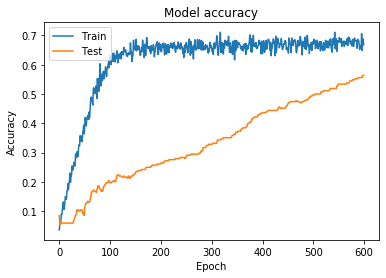

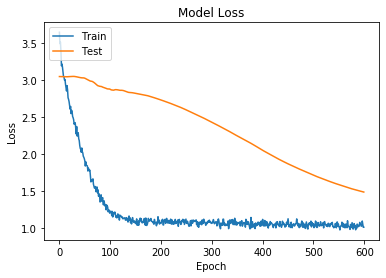

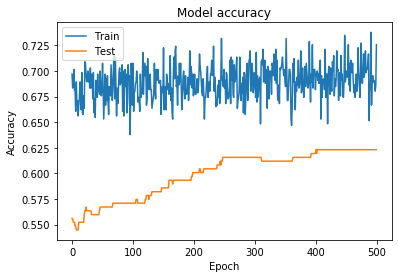

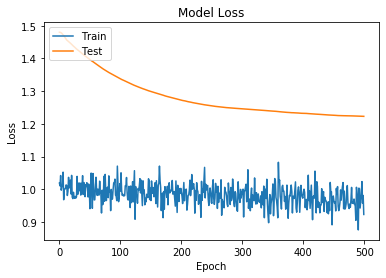

In [11]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Train and test on GT_split 2

In [12]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_2.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_2.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 270/270 [00:00<00:00, 325.46it/s]


In [13]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [14]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 658 samples, validate on 270 samples
Epoch 1/600
658/658 [==============================] - 3s 5ms/step - loss: 3.7625 - accuracy: 0.0456 - val_loss: 3.0440 - val_accuracy: 0.0815
Epoch 2/600
658/658 [==============================] - 0s 164us/step - loss: 3.6083 - accuracy: 0.0623 - val_loss: 3.0431 - val_accuracy: 0.0667
Epoch 3/600
658/658 [==============================] - 0s 153us/step - loss: 3.4016 - accuracy: 0.0745 - val_loss: 3.0412 - val_accuracy: 0.0889
Epoch 4/600
658/658 [==============================] - 0s 136us/step - loss: 3.3082 - accuracy: 0.0775 - val_loss: 3.0390 - val_accuracy: 0.0926
Epoch 5/600
658/658 [==============================] - 0s 136us/step - loss: 3.2278 - accuracy: 0.0957 - val_loss: 3.0370 - val_accuracy: 0.0704
Epoch 6/600
658/658 [==============================] - 0s 143us/step - loss: 3.2187 - accuracy: 0.0942 - val_loss: 3.0359 - val_accuracy: 0.0519
Epoch 7/600
658/658 [==============================] - 0s 140us/step - loss: 3.0378 - 

Epoch 57/600
658/658 [==============================] - 0s 137us/step - loss: 1.6210 - accuracy: 0.4742 - val_loss: 2.9114 - val_accuracy: 0.1963
Epoch 58/600
658/658 [==============================] - 0s 140us/step - loss: 1.5805 - accuracy: 0.5015 - val_loss: 2.9079 - val_accuracy: 0.1963
Epoch 59/600
658/658 [==============================] - 0s 140us/step - loss: 1.5764 - accuracy: 0.5000 - val_loss: 2.9024 - val_accuracy: 0.1963
Epoch 60/600
658/658 [==============================] - 0s 138us/step - loss: 1.5734 - accuracy: 0.5046 - val_loss: 2.8971 - val_accuracy: 0.2037
Epoch 61/600
658/658 [==============================] - 0s 143us/step - loss: 1.5950 - accuracy: 0.4696 - val_loss: 2.8925 - val_accuracy: 0.2000
Epoch 62/600
658/658 [==============================] - 0s 130us/step - loss: 1.5526 - accuracy: 0.4954 - val_loss: 2.8924 - val_accuracy: 0.2074
Epoch 63/600
658/658 [==============================] - 0s 130us/step - loss: 1.5634 - accuracy: 0.5152 - val_loss: 2.8935 -

658/658 [==============================] - 0s 139us/step - loss: 1.3713 - accuracy: 0.5684 - val_loss: 2.9859 - val_accuracy: 0.1778
Epoch 114/600
658/658 [==============================] - 0s 134us/step - loss: 1.3522 - accuracy: 0.5760 - val_loss: 2.9869 - val_accuracy: 0.1778
Epoch 115/600
658/658 [==============================] - 0s 134us/step - loss: 1.4103 - accuracy: 0.5243 - val_loss: 2.9888 - val_accuracy: 0.1815
Epoch 116/600
658/658 [==============================] - 0s 136us/step - loss: 1.3584 - accuracy: 0.5836 - val_loss: 2.9898 - val_accuracy: 0.1815
Epoch 117/600
658/658 [==============================] - 0s 129us/step - loss: 1.4126 - accuracy: 0.5456 - val_loss: 2.9912 - val_accuracy: 0.1815
Epoch 118/600
658/658 [==============================] - 0s 130us/step - loss: 1.3627 - accuracy: 0.5532 - val_loss: 2.9927 - val_accuracy: 0.1815
Epoch 119/600
658/658 [==============================] - 0s 136us/step - loss: 1.3893 - accuracy: 0.5441 - val_loss: 2.9944 - val_ac

Epoch 169/600
658/658 [==============================] - 0s 125us/step - loss: 1.3659 - accuracy: 0.5593 - val_loss: 2.9688 - val_accuracy: 0.2074
Epoch 170/600
658/658 [==============================] - 0s 129us/step - loss: 1.3930 - accuracy: 0.5638 - val_loss: 2.9671 - val_accuracy: 0.2074
Epoch 171/600
658/658 [==============================] - 0s 126us/step - loss: 1.3717 - accuracy: 0.5684 - val_loss: 2.9650 - val_accuracy: 0.2111
Epoch 172/600
658/658 [==============================] - 0s 127us/step - loss: 1.3450 - accuracy: 0.5669 - val_loss: 2.9631 - val_accuracy: 0.2111
Epoch 173/600
658/658 [==============================] - 0s 129us/step - loss: 1.3910 - accuracy: 0.5456 - val_loss: 2.9616 - val_accuracy: 0.2111
Epoch 174/600
658/658 [==============================] - 0s 128us/step - loss: 1.4259 - accuracy: 0.5502 - val_loss: 2.9595 - val_accuracy: 0.2111
Epoch 175/600
658/658 [==============================] - 0s 125us/step - loss: 1.3428 - accuracy: 0.5578 - val_loss: 2

Epoch 225/600
658/658 [==============================] - 0s 138us/step - loss: 1.3925 - accuracy: 0.5426 - val_loss: 2.8230 - val_accuracy: 0.2593
Epoch 226/600
658/658 [==============================] - 0s 132us/step - loss: 1.3455 - accuracy: 0.5745 - val_loss: 2.8198 - val_accuracy: 0.2593
Epoch 227/600
658/658 [==============================] - 0s 132us/step - loss: 1.4006 - accuracy: 0.5517 - val_loss: 2.8167 - val_accuracy: 0.2593
Epoch 228/600
658/658 [==============================] - 0s 132us/step - loss: 1.3869 - accuracy: 0.5456 - val_loss: 2.8131 - val_accuracy: 0.2593
Epoch 229/600
658/658 [==============================] - 0s 139us/step - loss: 1.3285 - accuracy: 0.5821 - val_loss: 2.8096 - val_accuracy: 0.2630
Epoch 230/600
658/658 [==============================] - 0s 129us/step - loss: 1.3372 - accuracy: 0.5729 - val_loss: 2.8063 - val_accuracy: 0.2630
Epoch 231/600
658/658 [==============================] - 0s 130us/step - loss: 1.3836 - accuracy: 0.5745 - val_loss: 2

Epoch 281/600
658/658 [==============================] - 0s 131us/step - loss: 1.3509 - accuracy: 0.5851 - val_loss: 2.6380 - val_accuracy: 0.3074
Epoch 282/600
658/658 [==============================] - 0s 127us/step - loss: 1.4048 - accuracy: 0.5471 - val_loss: 2.6348 - val_accuracy: 0.3074
Epoch 283/600
658/658 [==============================] - 0s 131us/step - loss: 1.4220 - accuracy: 0.5547 - val_loss: 2.6314 - val_accuracy: 0.3111
Epoch 284/600
658/658 [==============================] - 0s 124us/step - loss: 1.4180 - accuracy: 0.5426 - val_loss: 2.6281 - val_accuracy: 0.3111
Epoch 285/600
658/658 [==============================] - 0s 126us/step - loss: 1.3659 - accuracy: 0.5486 - val_loss: 2.6246 - val_accuracy: 0.3111
Epoch 286/600
658/658 [==============================] - 0s 131us/step - loss: 1.3103 - accuracy: 0.5973 - val_loss: 2.6210 - val_accuracy: 0.3074
Epoch 287/600
658/658 [==============================] - 0s 127us/step - loss: 1.3283 - accuracy: 0.5927 - val_loss: 2

Epoch 337/600
658/658 [==============================] - 0s 128us/step - loss: 1.3313 - accuracy: 0.5669 - val_loss: 2.4441 - val_accuracy: 0.3519
Epoch 338/600
658/658 [==============================] - 0s 128us/step - loss: 1.3589 - accuracy: 0.5623 - val_loss: 2.4408 - val_accuracy: 0.3519
Epoch 339/600
658/658 [==============================] - 0s 125us/step - loss: 1.3336 - accuracy: 0.5775 - val_loss: 2.4377 - val_accuracy: 0.3519
Epoch 340/600
658/658 [==============================] - 0s 129us/step - loss: 1.3540 - accuracy: 0.5486 - val_loss: 2.4340 - val_accuracy: 0.3519
Epoch 341/600
658/658 [==============================] - 0s 131us/step - loss: 1.3684 - accuracy: 0.5714 - val_loss: 2.4310 - val_accuracy: 0.3519
Epoch 342/600
658/658 [==============================] - 0s 129us/step - loss: 1.3718 - accuracy: 0.5897 - val_loss: 2.4275 - val_accuracy: 0.3556
Epoch 343/600
658/658 [==============================] - 0s 126us/step - loss: 1.3952 - accuracy: 0.5289 - val_loss: 2

Epoch 393/600
658/658 [==============================] - 0s 134us/step - loss: 1.3736 - accuracy: 0.5836 - val_loss: 2.2352 - val_accuracy: 0.3815
Epoch 394/600
658/658 [==============================] - 0s 128us/step - loss: 1.3422 - accuracy: 0.5760 - val_loss: 2.2315 - val_accuracy: 0.3852
Epoch 395/600
658/658 [==============================] - 0s 125us/step - loss: 1.3666 - accuracy: 0.5745 - val_loss: 2.2275 - val_accuracy: 0.3852
Epoch 396/600
658/658 [==============================] - 0s 137us/step - loss: 1.3407 - accuracy: 0.5669 - val_loss: 2.2234 - val_accuracy: 0.3889
Epoch 397/600
658/658 [==============================] - 0s 128us/step - loss: 1.3220 - accuracy: 0.5593 - val_loss: 2.2198 - val_accuracy: 0.3926
Epoch 398/600
658/658 [==============================] - 0s 129us/step - loss: 1.3795 - accuracy: 0.5441 - val_loss: 2.2157 - val_accuracy: 0.3926
Epoch 399/600
658/658 [==============================] - 0s 132us/step - loss: 1.3231 - accuracy: 0.5745 - val_loss: 2

Epoch 449/600
658/658 [==============================] - 0s 130us/step - loss: 1.3469 - accuracy: 0.5760 - val_loss: 2.0141 - val_accuracy: 0.4148
Epoch 450/600
658/658 [==============================] - 0s 125us/step - loss: 1.3193 - accuracy: 0.5638 - val_loss: 2.0102 - val_accuracy: 0.4185
Epoch 451/600
658/658 [==============================] - 0s 127us/step - loss: 1.3490 - accuracy: 0.5729 - val_loss: 2.0063 - val_accuracy: 0.4222
Epoch 452/600
658/658 [==============================] - 0s 132us/step - loss: 1.3633 - accuracy: 0.5684 - val_loss: 2.0022 - val_accuracy: 0.4222
Epoch 453/600
658/658 [==============================] - 0s 132us/step - loss: 1.3427 - accuracy: 0.5714 - val_loss: 1.9982 - val_accuracy: 0.4222
Epoch 454/600
658/658 [==============================] - 0s 130us/step - loss: 1.3366 - accuracy: 0.5502 - val_loss: 1.9945 - val_accuracy: 0.4222
Epoch 455/600
658/658 [==============================] - 0s 125us/step - loss: 1.3154 - accuracy: 0.5760 - val_loss: 1

Epoch 505/600
658/658 [==============================] - 0s 132us/step - loss: 1.3243 - accuracy: 0.5851 - val_loss: 1.8054 - val_accuracy: 0.4630
Epoch 506/600
658/658 [==============================] - 0s 129us/step - loss: 1.3119 - accuracy: 0.5714 - val_loss: 1.8019 - val_accuracy: 0.4630
Epoch 507/600
658/658 [==============================] - 0s 129us/step - loss: 1.3280 - accuracy: 0.5821 - val_loss: 1.7987 - val_accuracy: 0.4630
Epoch 508/600
658/658 [==============================] - 0s 127us/step - loss: 1.3650 - accuracy: 0.5699 - val_loss: 1.7955 - val_accuracy: 0.4667
Epoch 509/600
658/658 [==============================] - 0s 126us/step - loss: 1.3439 - accuracy: 0.5897 - val_loss: 1.7923 - val_accuracy: 0.4667
Epoch 510/600
658/658 [==============================] - 0s 128us/step - loss: 1.3542 - accuracy: 0.5836 - val_loss: 1.7888 - val_accuracy: 0.4704
Epoch 511/600
658/658 [==============================] - 0s 128us/step - loss: 1.3089 - accuracy: 0.5638 - val_loss: 1

Epoch 561/600
658/658 [==============================] - 0s 129us/step - loss: 1.3478 - accuracy: 0.5547 - val_loss: 1.6401 - val_accuracy: 0.5037
Epoch 562/600
658/658 [==============================] - 0s 131us/step - loss: 1.3159 - accuracy: 0.5638 - val_loss: 1.6373 - val_accuracy: 0.5037
Epoch 563/600
658/658 [==============================] - 0s 129us/step - loss: 1.3204 - accuracy: 0.5881 - val_loss: 1.6346 - val_accuracy: 0.5037
Epoch 564/600
658/658 [==============================] - 0s 128us/step - loss: 1.3307 - accuracy: 0.5638 - val_loss: 1.6320 - val_accuracy: 0.5037
Epoch 565/600
658/658 [==============================] - 0s 127us/step - loss: 1.2967 - accuracy: 0.5805 - val_loss: 1.6295 - val_accuracy: 0.5037
Epoch 566/600
658/658 [==============================] - 0s 135us/step - loss: 1.2873 - accuracy: 0.5745 - val_loss: 1.6271 - val_accuracy: 0.5074
Epoch 567/600
658/658 [==============================] - 0s 131us/step - loss: 1.2980 - accuracy: 0.5760 - val_loss: 1

Epoch 17/500
658/658 [==============================] - 0s 139us/step - loss: 1.2706 - accuracy: 0.5821 - val_loss: 1.5067 - val_accuracy: 0.5407
Epoch 18/500
658/658 [==============================] - 0s 136us/step - loss: 1.2711 - accuracy: 0.6049 - val_loss: 1.5047 - val_accuracy: 0.5407
Epoch 19/500
658/658 [==============================] - 0s 126us/step - loss: 1.2522 - accuracy: 0.6079 - val_loss: 1.5027 - val_accuracy: 0.5444
Epoch 20/500
658/658 [==============================] - 0s 134us/step - loss: 1.3109 - accuracy: 0.5957 - val_loss: 1.5005 - val_accuracy: 0.5444
Epoch 21/500
658/658 [==============================] - 0s 131us/step - loss: 1.2776 - accuracy: 0.5881 - val_loss: 1.4982 - val_accuracy: 0.5481
Epoch 22/500
658/658 [==============================] - 0s 132us/step - loss: 1.2907 - accuracy: 0.5836 - val_loss: 1.4963 - val_accuracy: 0.5519
Epoch 23/500
658/658 [==============================] - 0s 130us/step - loss: 1.2214 - accuracy: 0.6109 - val_loss: 1.4943 -

Epoch 74/500
658/658 [==============================] - 0s 141us/step - loss: 1.2290 - accuracy: 0.6170 - val_loss: 1.4030 - val_accuracy: 0.5815
Epoch 75/500
658/658 [==============================] - 0s 133us/step - loss: 1.3130 - accuracy: 0.5805 - val_loss: 1.4015 - val_accuracy: 0.5815
Epoch 76/500
658/658 [==============================] - 0s 140us/step - loss: 1.2799 - accuracy: 0.5988 - val_loss: 1.4000 - val_accuracy: 0.5815
Epoch 77/500
658/658 [==============================] - 0s 141us/step - loss: 1.2861 - accuracy: 0.5775 - val_loss: 1.3986 - val_accuracy: 0.5815
Epoch 78/500
658/658 [==============================] - 0s 139us/step - loss: 1.2702 - accuracy: 0.6079 - val_loss: 1.3973 - val_accuracy: 0.5815
Epoch 79/500
658/658 [==============================] - 0s 136us/step - loss: 1.2837 - accuracy: 0.5912 - val_loss: 1.3959 - val_accuracy: 0.5815
Epoch 80/500
658/658 [==============================] - 0s 138us/step - loss: 1.3015 - accuracy: 0.5881 - val_loss: 1.3946 -

Epoch 130/500
658/658 [==============================] - 0s 134us/step - loss: 1.2633 - accuracy: 0.5851 - val_loss: 1.3383 - val_accuracy: 0.6000
Epoch 131/500
658/658 [==============================] - 0s 133us/step - loss: 1.2588 - accuracy: 0.6155 - val_loss: 1.3375 - val_accuracy: 0.6000
Epoch 132/500
658/658 [==============================] - 0s 138us/step - loss: 1.2344 - accuracy: 0.5821 - val_loss: 1.3366 - val_accuracy: 0.6000
Epoch 133/500
658/658 [==============================] - 0s 134us/step - loss: 1.2166 - accuracy: 0.6125 - val_loss: 1.3357 - val_accuracy: 0.6000
Epoch 134/500
658/658 [==============================] - 0s 131us/step - loss: 1.2616 - accuracy: 0.6003 - val_loss: 1.3349 - val_accuracy: 0.6000
Epoch 135/500
658/658 [==============================] - 0s 141us/step - loss: 1.2394 - accuracy: 0.6003 - val_loss: 1.3339 - val_accuracy: 0.6000
Epoch 136/500
658/658 [==============================] - 0s 130us/step - loss: 1.2416 - accuracy: 0.6109 - val_loss: 1

Epoch 186/500
658/658 [==============================] - 0s 123us/step - loss: 1.2329 - accuracy: 0.5988 - val_loss: 1.2972 - val_accuracy: 0.6148
Epoch 187/500
658/658 [==============================] - 0s 129us/step - loss: 1.2964 - accuracy: 0.5821 - val_loss: 1.2966 - val_accuracy: 0.6185
Epoch 188/500
658/658 [==============================] - 0s 128us/step - loss: 1.2296 - accuracy: 0.5988 - val_loss: 1.2960 - val_accuracy: 0.6185
Epoch 189/500
658/658 [==============================] - 0s 128us/step - loss: 1.2762 - accuracy: 0.5973 - val_loss: 1.2954 - val_accuracy: 0.6185
Epoch 190/500
658/658 [==============================] - 0s 122us/step - loss: 1.2711 - accuracy: 0.5988 - val_loss: 1.2948 - val_accuracy: 0.6185
Epoch 191/500
658/658 [==============================] - 0s 125us/step - loss: 1.2364 - accuracy: 0.5957 - val_loss: 1.2943 - val_accuracy: 0.6185
Epoch 192/500
658/658 [==============================] - 0s 124us/step - loss: 1.2876 - accuracy: 0.5988 - val_loss: 1

Epoch 242/500
658/658 [==============================] - 0s 127us/step - loss: 1.2543 - accuracy: 0.6033 - val_loss: 1.2730 - val_accuracy: 0.6222
Epoch 243/500
658/658 [==============================] - 0s 129us/step - loss: 1.2565 - accuracy: 0.5988 - val_loss: 1.2726 - val_accuracy: 0.6222
Epoch 244/500
658/658 [==============================] - 0s 123us/step - loss: 1.2275 - accuracy: 0.6170 - val_loss: 1.2722 - val_accuracy: 0.6222
Epoch 245/500
658/658 [==============================] - 0s 129us/step - loss: 1.2850 - accuracy: 0.6033 - val_loss: 1.2719 - val_accuracy: 0.6222
Epoch 246/500
658/658 [==============================] - 0s 123us/step - loss: 1.2994 - accuracy: 0.5653 - val_loss: 1.2715 - val_accuracy: 0.6222
Epoch 247/500
658/658 [==============================] - 0s 126us/step - loss: 1.2409 - accuracy: 0.6277 - val_loss: 1.2711 - val_accuracy: 0.6222
Epoch 248/500
658/658 [==============================] - 0s 134us/step - loss: 1.2410 - accuracy: 0.6064 - val_loss: 1

Epoch 298/500
658/658 [==============================] - 0s 128us/step - loss: 1.2522 - accuracy: 0.5942 - val_loss: 1.2574 - val_accuracy: 0.6259
Epoch 299/500
658/658 [==============================] - 0s 134us/step - loss: 1.2156 - accuracy: 0.6155 - val_loss: 1.2573 - val_accuracy: 0.6259
Epoch 300/500
658/658 [==============================] - 0s 128us/step - loss: 1.2615 - accuracy: 0.5942 - val_loss: 1.2572 - val_accuracy: 0.6259
Epoch 301/500
658/658 [==============================] - 0s 132us/step - loss: 1.2624 - accuracy: 0.6125 - val_loss: 1.2569 - val_accuracy: 0.6259
Epoch 302/500
658/658 [==============================] - 0s 130us/step - loss: 1.2088 - accuracy: 0.6155 - val_loss: 1.2567 - val_accuracy: 0.6259
Epoch 303/500
658/658 [==============================] - 0s 126us/step - loss: 1.2210 - accuracy: 0.6140 - val_loss: 1.2567 - val_accuracy: 0.6259
Epoch 304/500
658/658 [==============================] - 0s 125us/step - loss: 1.3015 - accuracy: 0.5821 - val_loss: 1

Epoch 354/500
658/658 [==============================] - 0s 149us/step - loss: 1.2281 - accuracy: 0.6018 - val_loss: 1.2483 - val_accuracy: 0.6222
Epoch 355/500
658/658 [==============================] - 0s 142us/step - loss: 1.2515 - accuracy: 0.6155 - val_loss: 1.2482 - val_accuracy: 0.6222
Epoch 356/500
658/658 [==============================] - 0s 132us/step - loss: 1.2007 - accuracy: 0.6246 - val_loss: 1.2481 - val_accuracy: 0.6222
Epoch 357/500
658/658 [==============================] - 0s 128us/step - loss: 1.2197 - accuracy: 0.6018 - val_loss: 1.2480 - val_accuracy: 0.6222
Epoch 358/500
658/658 [==============================] - 0s 127us/step - loss: 1.2749 - accuracy: 0.5957 - val_loss: 1.2477 - val_accuracy: 0.6222
Epoch 359/500
658/658 [==============================] - 0s 133us/step - loss: 1.2602 - accuracy: 0.5912 - val_loss: 1.2477 - val_accuracy: 0.6222
Epoch 360/500
658/658 [==============================] - 0s 135us/step - loss: 1.2407 - accuracy: 0.6109 - val_loss: 1

Epoch 410/500
658/658 [==============================] - 0s 126us/step - loss: 1.2585 - accuracy: 0.6003 - val_loss: 1.2425 - val_accuracy: 0.6222
Epoch 411/500
658/658 [==============================] - 0s 128us/step - loss: 1.2629 - accuracy: 0.5821 - val_loss: 1.2425 - val_accuracy: 0.6222
Epoch 412/500
658/658 [==============================] - 0s 123us/step - loss: 1.2113 - accuracy: 0.6094 - val_loss: 1.2423 - val_accuracy: 0.6222
Epoch 413/500
658/658 [==============================] - 0s 131us/step - loss: 1.2570 - accuracy: 0.6109 - val_loss: 1.2422 - val_accuracy: 0.6222
Epoch 414/500
658/658 [==============================] - 0s 130us/step - loss: 1.2073 - accuracy: 0.6140 - val_loss: 1.2420 - val_accuracy: 0.6222
Epoch 415/500
658/658 [==============================] - 0s 130us/step - loss: 1.2061 - accuracy: 0.6079 - val_loss: 1.2418 - val_accuracy: 0.6222
Epoch 416/500
658/658 [==============================] - 0s 125us/step - loss: 1.2149 - accuracy: 0.6033 - val_loss: 1

Epoch 466/500
658/658 [==============================] - 0s 123us/step - loss: 1.2459 - accuracy: 0.6003 - val_loss: 1.2378 - val_accuracy: 0.6185
Epoch 467/500
658/658 [==============================] - 0s 122us/step - loss: 1.2177 - accuracy: 0.6125 - val_loss: 1.2377 - val_accuracy: 0.6185
Epoch 468/500
658/658 [==============================] - 0s 125us/step - loss: 1.2317 - accuracy: 0.6216 - val_loss: 1.2376 - val_accuracy: 0.6185
Epoch 469/500
658/658 [==============================] - 0s 125us/step - loss: 1.2344 - accuracy: 0.6261 - val_loss: 1.2376 - val_accuracy: 0.6185
Epoch 470/500
658/658 [==============================] - 0s 125us/step - loss: 1.1919 - accuracy: 0.6064 - val_loss: 1.2375 - val_accuracy: 0.6185
Epoch 471/500
658/658 [==============================] - 0s 124us/step - loss: 1.1873 - accuracy: 0.6231 - val_loss: 1.2374 - val_accuracy: 0.6185
Epoch 472/500
658/658 [==============================] - 0s 129us/step - loss: 1.2811 - accuracy: 0.6064 - val_loss: 1

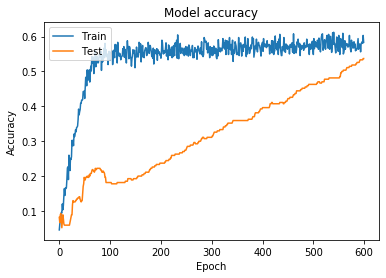

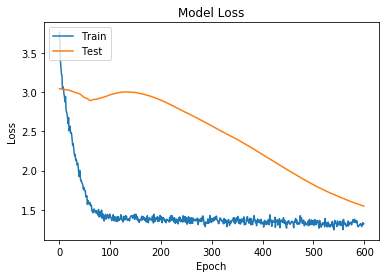

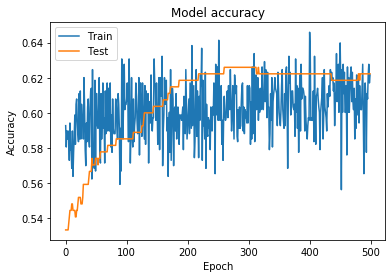

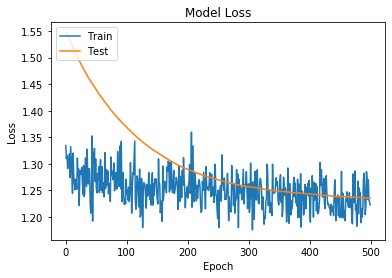

In [15]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Train and test on GT_split 3

In [20]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_3.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_3.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 265/265 [00:00<00:00, 333.05it/s]


In [21]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [22]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 663 samples, validate on 265 samples
Epoch 1/600
663/663 [==============================] - 5s 7ms/step - loss: 3.7925 - accuracy: 0.0422 - val_loss: 3.0452 - val_accuracy: 0.0340
Epoch 2/600
663/663 [==============================] - 0s 174us/step - loss: 3.5479 - accuracy: 0.0739 - val_loss: 3.0446 - val_accuracy: 0.0491
Epoch 3/600
663/663 [==============================] - 0s 152us/step - loss: 3.4327 - accuracy: 0.0633 - val_loss: 3.0432 - val_accuracy: 0.0604
Epoch 4/600
663/663 [==============================] - 0s 151us/step - loss: 3.3203 - accuracy: 0.1041 - val_loss: 3.0419 - val_accuracy: 0.0679
Epoch 5/600
663/663 [==============================] - 0s 153us/step - loss: 3.2685 - accuracy: 0.0965 - val_loss: 3.0409 - val_accuracy: 0.0717
Epoch 6/600
663/663 [==============================] - 0s 142us/step - loss: 3.1792 - accuracy: 0.1222 - val_loss: 3.0400 - val_accuracy: 0.0679
Epoch 7/600
663/663 [==============================] - 0s 144us/step - loss: 3.1698 - 

Epoch 57/600
663/663 [==============================] - 0s 137us/step - loss: 1.6963 - accuracy: 0.4857 - val_loss: 3.3388 - val_accuracy: 0.0792
Epoch 58/600
663/663 [==============================] - 0s 141us/step - loss: 1.6765 - accuracy: 0.4902 - val_loss: 3.3553 - val_accuracy: 0.0792
Epoch 59/600
663/663 [==============================] - 0s 145us/step - loss: 1.5824 - accuracy: 0.5158 - val_loss: 3.3747 - val_accuracy: 0.0792
Epoch 60/600
663/663 [==============================] - 0s 140us/step - loss: 1.6033 - accuracy: 0.4872 - val_loss: 3.3945 - val_accuracy: 0.0792
Epoch 61/600
663/663 [==============================] - 0s 140us/step - loss: 1.5955 - accuracy: 0.4842 - val_loss: 3.4176 - val_accuracy: 0.0792
Epoch 62/600
663/663 [==============================] - 0s 142us/step - loss: 1.5416 - accuracy: 0.5128 - val_loss: 3.4454 - val_accuracy: 0.0792
Epoch 63/600
663/663 [==============================] - 0s 140us/step - loss: 1.5446 - accuracy: 0.4962 - val_loss: 3.4740 -

663/663 [==============================] - 0s 130us/step - loss: 1.0914 - accuracy: 0.6486 - val_loss: 4.1019 - val_accuracy: 0.1170
Epoch 114/600
663/663 [==============================] - 0s 142us/step - loss: 1.0587 - accuracy: 0.6682 - val_loss: 4.1025 - val_accuracy: 0.1170
Epoch 115/600
663/663 [==============================] - 0s 133us/step - loss: 1.1131 - accuracy: 0.6350 - val_loss: 4.1067 - val_accuracy: 0.1170
Epoch 116/600
663/663 [==============================] - 0s 128us/step - loss: 1.0732 - accuracy: 0.6652 - val_loss: 4.1107 - val_accuracy: 0.1170
Epoch 117/600
663/663 [==============================] - 0s 130us/step - loss: 1.0763 - accuracy: 0.6440 - val_loss: 4.1164 - val_accuracy: 0.1170
Epoch 118/600
663/663 [==============================] - 0s 129us/step - loss: 1.0323 - accuracy: 0.6787 - val_loss: 4.1193 - val_accuracy: 0.1170
Epoch 119/600
663/663 [==============================] - 0s 131us/step - loss: 1.0370 - accuracy: 0.6742 - val_loss: 4.1197 - val_ac

Epoch 169/600
663/663 [==============================] - 0s 137us/step - loss: 0.9944 - accuracy: 0.6848 - val_loss: 3.9358 - val_accuracy: 0.1283
Epoch 170/600
663/663 [==============================] - 0s 132us/step - loss: 0.9821 - accuracy: 0.7029 - val_loss: 3.9288 - val_accuracy: 0.1283
Epoch 171/600
663/663 [==============================] - 0s 132us/step - loss: 1.0281 - accuracy: 0.6893 - val_loss: 3.9210 - val_accuracy: 0.1321
Epoch 172/600
663/663 [==============================] - 0s 140us/step - loss: 0.9783 - accuracy: 0.6953 - val_loss: 3.9131 - val_accuracy: 0.1358
Epoch 173/600
663/663 [==============================] - 0s 139us/step - loss: 0.9943 - accuracy: 0.6833 - val_loss: 3.9047 - val_accuracy: 0.1358
Epoch 174/600
663/663 [==============================] - 0s 131us/step - loss: 0.9905 - accuracy: 0.6953 - val_loss: 3.8971 - val_accuracy: 0.1358
Epoch 175/600
663/663 [==============================] - 0s 132us/step - loss: 0.9539 - accuracy: 0.6998 - val_loss: 3

Epoch 225/600
663/663 [==============================] - 0s 136us/step - loss: 0.9641 - accuracy: 0.7149 - val_loss: 3.4600 - val_accuracy: 0.1585
Epoch 226/600
663/663 [==============================] - 0s 132us/step - loss: 0.9990 - accuracy: 0.6757 - val_loss: 3.4511 - val_accuracy: 0.1585
Epoch 227/600
663/663 [==============================] - 0s 136us/step - loss: 1.0316 - accuracy: 0.6471 - val_loss: 3.4423 - val_accuracy: 0.1585
Epoch 228/600
663/663 [==============================] - 0s 144us/step - loss: 0.9952 - accuracy: 0.6938 - val_loss: 3.4338 - val_accuracy: 0.1623
Epoch 229/600
663/663 [==============================] - 0s 138us/step - loss: 0.9756 - accuracy: 0.6787 - val_loss: 3.4249 - val_accuracy: 0.1623
Epoch 230/600
663/663 [==============================] - 0s 136us/step - loss: 0.9848 - accuracy: 0.7179 - val_loss: 3.4158 - val_accuracy: 0.1623
Epoch 231/600
663/663 [==============================] - 0s 133us/step - loss: 1.0449 - accuracy: 0.6833 - val_loss: 3

Epoch 281/600
663/663 [==============================] - 0s 137us/step - loss: 0.9411 - accuracy: 0.6878 - val_loss: 2.9735 - val_accuracy: 0.2453
Epoch 282/600
663/663 [==============================] - 0s 137us/step - loss: 0.9920 - accuracy: 0.6983 - val_loss: 2.9657 - val_accuracy: 0.2415
Epoch 283/600
663/663 [==============================] - 0s 142us/step - loss: 0.9972 - accuracy: 0.6802 - val_loss: 2.9578 - val_accuracy: 0.2415
Epoch 284/600
663/663 [==============================] - 0s 131us/step - loss: 0.9646 - accuracy: 0.7014 - val_loss: 2.9498 - val_accuracy: 0.2415
Epoch 285/600
663/663 [==============================] - 0s 138us/step - loss: 1.0055 - accuracy: 0.6787 - val_loss: 2.9415 - val_accuracy: 0.2415
Epoch 286/600
663/663 [==============================] - 0s 139us/step - loss: 0.9631 - accuracy: 0.6908 - val_loss: 2.9340 - val_accuracy: 0.2453
Epoch 287/600
663/663 [==============================] - 0s 136us/step - loss: 0.9950 - accuracy: 0.6938 - val_loss: 2

Epoch 337/600
663/663 [==============================] - 0s 132us/step - loss: 0.9579 - accuracy: 0.7029 - val_loss: 2.5709 - val_accuracy: 0.2755
Epoch 338/600
663/663 [==============================] - 0s 134us/step - loss: 0.9389 - accuracy: 0.7315 - val_loss: 2.5649 - val_accuracy: 0.2755
Epoch 339/600
663/663 [==============================] - 0s 137us/step - loss: 0.9578 - accuracy: 0.6833 - val_loss: 2.5584 - val_accuracy: 0.2830
Epoch 340/600
663/663 [==============================] - 0s 136us/step - loss: 0.9859 - accuracy: 0.7029 - val_loss: 2.5521 - val_accuracy: 0.2830
Epoch 341/600
663/663 [==============================] - 0s 136us/step - loss: 0.9944 - accuracy: 0.7029 - val_loss: 2.5452 - val_accuracy: 0.2830
Epoch 342/600
663/663 [==============================] - 0s 137us/step - loss: 0.9798 - accuracy: 0.6848 - val_loss: 2.5389 - val_accuracy: 0.2830
Epoch 343/600
663/663 [==============================] - 0s 129us/step - loss: 1.0179 - accuracy: 0.6757 - val_loss: 2

Epoch 393/600
663/663 [==============================] - 0s 129us/step - loss: 1.0000 - accuracy: 0.6802 - val_loss: 2.2327 - val_accuracy: 0.3283
Epoch 394/600
663/663 [==============================] - 0s 134us/step - loss: 0.9269 - accuracy: 0.7195 - val_loss: 2.2273 - val_accuracy: 0.3358
Epoch 395/600
663/663 [==============================] - 0s 127us/step - loss: 0.9440 - accuracy: 0.7134 - val_loss: 2.2217 - val_accuracy: 0.3321
Epoch 396/600
663/663 [==============================] - 0s 128us/step - loss: 0.9859 - accuracy: 0.6923 - val_loss: 2.2162 - val_accuracy: 0.3358
Epoch 397/600
663/663 [==============================] - 0s 127us/step - loss: 0.9679 - accuracy: 0.6968 - val_loss: 2.2113 - val_accuracy: 0.3358
Epoch 398/600
663/663 [==============================] - 0s 131us/step - loss: 0.9919 - accuracy: 0.6667 - val_loss: 2.2061 - val_accuracy: 0.3396
Epoch 399/600
663/663 [==============================] - 0s 134us/step - loss: 0.9921 - accuracy: 0.6938 - val_loss: 2

Epoch 449/600
663/663 [==============================] - 0s 133us/step - loss: 0.9516 - accuracy: 0.7089 - val_loss: 1.9630 - val_accuracy: 0.4189
Epoch 450/600
663/663 [==============================] - 0s 138us/step - loss: 0.9646 - accuracy: 0.6968 - val_loss: 1.9592 - val_accuracy: 0.4189
Epoch 451/600
663/663 [==============================] - 0s 130us/step - loss: 0.9055 - accuracy: 0.7195 - val_loss: 1.9550 - val_accuracy: 0.4226
Epoch 452/600
663/663 [==============================] - 0s 133us/step - loss: 0.9545 - accuracy: 0.7210 - val_loss: 1.9508 - val_accuracy: 0.4226
Epoch 453/600
663/663 [==============================] - 0s 128us/step - loss: 0.9629 - accuracy: 0.6923 - val_loss: 1.9467 - val_accuracy: 0.4264
Epoch 454/600
663/663 [==============================] - 0s 134us/step - loss: 0.9619 - accuracy: 0.6757 - val_loss: 1.9427 - val_accuracy: 0.4302
Epoch 455/600
663/663 [==============================] - 0s 136us/step - loss: 0.9568 - accuracy: 0.7149 - val_loss: 1

Epoch 505/600
663/663 [==============================] - 0s 133us/step - loss: 0.9284 - accuracy: 0.7330 - val_loss: 1.7627 - val_accuracy: 0.4830
Epoch 506/600
663/663 [==============================] - 0s 131us/step - loss: 0.9722 - accuracy: 0.6983 - val_loss: 1.7597 - val_accuracy: 0.4830
Epoch 507/600
663/663 [==============================] - 0s 129us/step - loss: 0.9226 - accuracy: 0.7210 - val_loss: 1.7568 - val_accuracy: 0.4830
Epoch 508/600
663/663 [==============================] - 0s 131us/step - loss: 0.9421 - accuracy: 0.7014 - val_loss: 1.7539 - val_accuracy: 0.4830
Epoch 509/600
663/663 [==============================] - 0s 134us/step - loss: 0.9374 - accuracy: 0.7240 - val_loss: 1.7511 - val_accuracy: 0.4830
Epoch 510/600
663/663 [==============================] - 0s 133us/step - loss: 0.9267 - accuracy: 0.7149 - val_loss: 1.7482 - val_accuracy: 0.4830
Epoch 511/600
663/663 [==============================] - 0s 135us/step - loss: 0.9679 - accuracy: 0.6968 - val_loss: 1

Epoch 561/600
663/663 [==============================] - 0s 127us/step - loss: 0.9529 - accuracy: 0.7210 - val_loss: 1.6196 - val_accuracy: 0.5245
Epoch 562/600
663/663 [==============================] - 0s 130us/step - loss: 0.9585 - accuracy: 0.6923 - val_loss: 1.6175 - val_accuracy: 0.5245
Epoch 563/600
663/663 [==============================] - 0s 131us/step - loss: 0.9416 - accuracy: 0.6983 - val_loss: 1.6153 - val_accuracy: 0.5245
Epoch 564/600
663/663 [==============================] - 0s 129us/step - loss: 0.9102 - accuracy: 0.7300 - val_loss: 1.6132 - val_accuracy: 0.5245
Epoch 565/600
663/663 [==============================] - 0s 133us/step - loss: 0.9694 - accuracy: 0.6878 - val_loss: 1.6110 - val_accuracy: 0.5208
Epoch 566/600
663/663 [==============================] - 0s 133us/step - loss: 0.9326 - accuracy: 0.7270 - val_loss: 1.6090 - val_accuracy: 0.5208
Epoch 567/600
663/663 [==============================] - 0s 128us/step - loss: 0.9524 - accuracy: 0.7014 - val_loss: 1

Epoch 17/500
663/663 [==============================] - 0s 139us/step - loss: 0.8384 - accuracy: 0.7541 - val_loss: 1.5777 - val_accuracy: 0.5283
Epoch 18/500
663/663 [==============================] - 0s 135us/step - loss: 0.8330 - accuracy: 0.7421 - val_loss: 1.5716 - val_accuracy: 0.5321
Epoch 19/500
663/663 [==============================] - 0s 127us/step - loss: 0.8502 - accuracy: 0.7496 - val_loss: 1.5624 - val_accuracy: 0.5358
Epoch 20/500
663/663 [==============================] - 0s 145us/step - loss: 0.8496 - accuracy: 0.7406 - val_loss: 1.5572 - val_accuracy: 0.5396
Epoch 21/500
663/663 [==============================] - 0s 129us/step - loss: 0.7790 - accuracy: 0.7602 - val_loss: 1.5529 - val_accuracy: 0.5509
Epoch 22/500
663/663 [==============================] - 0s 150us/step - loss: 0.8255 - accuracy: 0.7436 - val_loss: 1.5503 - val_accuracy: 0.5472
Epoch 23/500
663/663 [==============================] - 0s 141us/step - loss: 0.8211 - accuracy: 0.7526 - val_loss: 1.5480 -

Epoch 74/500
663/663 [==============================] - 0s 142us/step - loss: 0.6484 - accuracy: 0.7964 - val_loss: 1.4369 - val_accuracy: 0.5623
Epoch 75/500
663/663 [==============================] - 0s 141us/step - loss: 0.6962 - accuracy: 0.7979 - val_loss: 1.4357 - val_accuracy: 0.5623
Epoch 76/500
663/663 [==============================] - 0s 143us/step - loss: 0.6863 - accuracy: 0.8009 - val_loss: 1.4344 - val_accuracy: 0.5623
Epoch 77/500
663/663 [==============================] - 0s 142us/step - loss: 0.7429 - accuracy: 0.7677 - val_loss: 1.4329 - val_accuracy: 0.5623
Epoch 78/500
663/663 [==============================] - 0s 144us/step - loss: 0.7602 - accuracy: 0.7722 - val_loss: 1.4315 - val_accuracy: 0.5623
Epoch 79/500
663/663 [==============================] - 0s 143us/step - loss: 0.7216 - accuracy: 0.7828 - val_loss: 1.4301 - val_accuracy: 0.5623
Epoch 80/500
663/663 [==============================] - 0s 142us/step - loss: 0.7790 - accuracy: 0.7632 - val_loss: 1.4287 -

Epoch 130/500
663/663 [==============================] - 0s 134us/step - loss: 0.7309 - accuracy: 0.7813 - val_loss: 1.3802 - val_accuracy: 0.5660
Epoch 131/500
663/663 [==============================] - 0s 133us/step - loss: 0.7082 - accuracy: 0.7979 - val_loss: 1.3794 - val_accuracy: 0.5698
Epoch 132/500
663/663 [==============================] - 0s 135us/step - loss: 0.7288 - accuracy: 0.7647 - val_loss: 1.3787 - val_accuracy: 0.5698
Epoch 133/500
663/663 [==============================] - 0s 133us/step - loss: 0.6753 - accuracy: 0.8220 - val_loss: 1.3780 - val_accuracy: 0.5698
Epoch 134/500
663/663 [==============================] - 0s 135us/step - loss: 0.7181 - accuracy: 0.7572 - val_loss: 1.3773 - val_accuracy: 0.5698
Epoch 135/500
663/663 [==============================] - 0s 137us/step - loss: 0.7191 - accuracy: 0.7813 - val_loss: 1.3766 - val_accuracy: 0.5698
Epoch 136/500
663/663 [==============================] - 0s 141us/step - loss: 0.7506 - accuracy: 0.7873 - val_loss: 1

Epoch 186/500
663/663 [==============================] - 0s 135us/step - loss: 0.6949 - accuracy: 0.7964 - val_loss: 1.3504 - val_accuracy: 0.5887
Epoch 187/500
663/663 [==============================] - 0s 134us/step - loss: 0.7089 - accuracy: 0.7903 - val_loss: 1.3500 - val_accuracy: 0.5849
Epoch 188/500
663/663 [==============================] - 0s 136us/step - loss: 0.7122 - accuracy: 0.7873 - val_loss: 1.3496 - val_accuracy: 0.5887
Epoch 189/500
663/663 [==============================] - 0s 134us/step - loss: 0.7062 - accuracy: 0.7722 - val_loss: 1.3491 - val_accuracy: 0.5887
Epoch 190/500
663/663 [==============================] - 0s 133us/step - loss: 0.7246 - accuracy: 0.7692 - val_loss: 1.3488 - val_accuracy: 0.5887
Epoch 191/500
663/663 [==============================] - 0s 132us/step - loss: 0.7331 - accuracy: 0.7632 - val_loss: 1.3484 - val_accuracy: 0.5849
Epoch 192/500
663/663 [==============================] - 0s 133us/step - loss: 0.7327 - accuracy: 0.7813 - val_loss: 1

Epoch 242/500
663/663 [==============================] - 0s 131us/step - loss: 0.7063 - accuracy: 0.7934 - val_loss: 1.3356 - val_accuracy: 0.5887
Epoch 243/500
663/663 [==============================] - 0s 133us/step - loss: 0.6556 - accuracy: 0.8115 - val_loss: 1.3354 - val_accuracy: 0.5887
Epoch 244/500
663/663 [==============================] - 0s 135us/step - loss: 0.6935 - accuracy: 0.7949 - val_loss: 1.3351 - val_accuracy: 0.5887
Epoch 245/500
663/663 [==============================] - 0s 128us/step - loss: 0.6727 - accuracy: 0.7888 - val_loss: 1.3350 - val_accuracy: 0.5887
Epoch 246/500
663/663 [==============================] - 0s 134us/step - loss: 0.7898 - accuracy: 0.7768 - val_loss: 1.3348 - val_accuracy: 0.5887
Epoch 247/500
663/663 [==============================] - 0s 131us/step - loss: 0.7199 - accuracy: 0.7738 - val_loss: 1.3345 - val_accuracy: 0.5887
Epoch 248/500
663/663 [==============================] - 0s 133us/step - loss: 0.7113 - accuracy: 0.7843 - val_loss: 1

Epoch 298/500
663/663 [==============================] - 0s 140us/step - loss: 0.6935 - accuracy: 0.7964 - val_loss: 1.3270 - val_accuracy: 0.5962
Epoch 299/500
663/663 [==============================] - 0s 142us/step - loss: 0.6807 - accuracy: 0.7873 - val_loss: 1.3269 - val_accuracy: 0.5962
Epoch 300/500
663/663 [==============================] - 0s 142us/step - loss: 0.6985 - accuracy: 0.7692 - val_loss: 1.3269 - val_accuracy: 0.5962
Epoch 301/500
663/663 [==============================] - 0s 139us/step - loss: 0.6941 - accuracy: 0.7798 - val_loss: 1.3268 - val_accuracy: 0.5962
Epoch 302/500
663/663 [==============================] - 0s 140us/step - loss: 0.7296 - accuracy: 0.7692 - val_loss: 1.3267 - val_accuracy: 0.5962
Epoch 303/500
663/663 [==============================] - 0s 141us/step - loss: 0.7014 - accuracy: 0.7843 - val_loss: 1.3266 - val_accuracy: 0.5962
Epoch 304/500
663/663 [==============================] - 0s 130us/step - loss: 0.6955 - accuracy: 0.8039 - val_loss: 1

Epoch 354/500
663/663 [==============================] - 0s 132us/step - loss: 0.7191 - accuracy: 0.7828 - val_loss: 1.3220 - val_accuracy: 0.6038
Epoch 355/500
663/663 [==============================] - 0s 129us/step - loss: 0.6927 - accuracy: 0.8024 - val_loss: 1.3220 - val_accuracy: 0.6038
Epoch 356/500
663/663 [==============================] - 0s 136us/step - loss: 0.7036 - accuracy: 0.7949 - val_loss: 1.3218 - val_accuracy: 0.6038
Epoch 357/500
663/663 [==============================] - 0s 136us/step - loss: 0.7108 - accuracy: 0.7919 - val_loss: 1.3218 - val_accuracy: 0.6038
Epoch 358/500
663/663 [==============================] - 0s 133us/step - loss: 0.7114 - accuracy: 0.7768 - val_loss: 1.3217 - val_accuracy: 0.6038
Epoch 359/500
663/663 [==============================] - 0s 134us/step - loss: 0.6673 - accuracy: 0.7903 - val_loss: 1.3216 - val_accuracy: 0.6038
Epoch 360/500
663/663 [==============================] - 0s 135us/step - loss: 0.6415 - accuracy: 0.8100 - val_loss: 1

Epoch 410/500
663/663 [==============================] - 0s 133us/step - loss: 0.7538 - accuracy: 0.7662 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 411/500
663/663 [==============================] - 0s 135us/step - loss: 0.6544 - accuracy: 0.8009 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 412/500
663/663 [==============================] - 0s 139us/step - loss: 0.7229 - accuracy: 0.7677 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 413/500
663/663 [==============================] - 0s 131us/step - loss: 0.7186 - accuracy: 0.7738 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 414/500
663/663 [==============================] - 0s 136us/step - loss: 0.7197 - accuracy: 0.7677 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 415/500
663/663 [==============================] - 0s 133us/step - loss: 0.6464 - accuracy: 0.8130 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 416/500
663/663 [==============================] - 0s 132us/step - loss: 0.6820 - accuracy: 0.7919 - val_loss: 1

Epoch 466/500
663/663 [==============================] - 0s 136us/step - loss: 0.7016 - accuracy: 0.7828 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 467/500
663/663 [==============================] - 0s 134us/step - loss: 0.6956 - accuracy: 0.7949 - val_loss: 1.3171 - val_accuracy: 0.6038
Epoch 468/500
663/663 [==============================] - 0s 132us/step - loss: 0.7127 - accuracy: 0.7783 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 469/500
663/663 [==============================] - 0s 135us/step - loss: 0.7664 - accuracy: 0.7632 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 470/500
663/663 [==============================] - 0s 133us/step - loss: 0.6624 - accuracy: 0.7949 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 471/500
663/663 [==============================] - 0s 133us/step - loss: 0.6534 - accuracy: 0.7858 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 472/500
663/663 [==============================] - 0s 134us/step - loss: 0.6812 - accuracy: 0.7873 - val_loss: 1

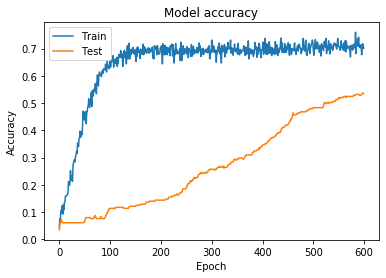

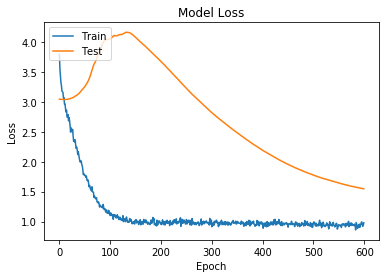

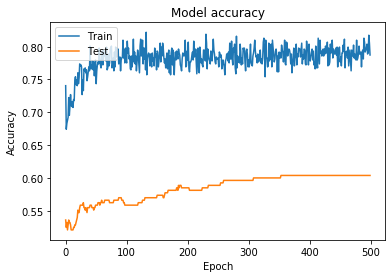

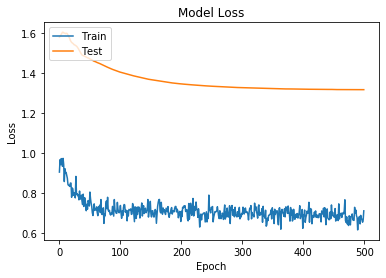

In [23]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Calculate average 

In [ ]:
(0.63+0.66+0.68)/3